In [62]:
import toy_problem

In [63]:
problem = toy_problem.GraphProblem(n_nodes=100, gamma = 0.9, regular=False)

In [64]:
planner = toy_problem.InterpolationPlanner(problem, n_components=2)

/home/de7281/miniconda3/envs/interp_env/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [65]:
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr

In [66]:
original_distances = -np.log(problem.occupancy_matrix + 1e-10)

/home/de7281/miniconda3/envs/interp_env/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/home/de7281/miniconda3/envs/interp_env/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/home/de7281/miniconda3/envs/interp_env/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/home/de7281/miniconda3/envs/interp_env/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/home/de7281/miniconda3/envs/interp_env/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


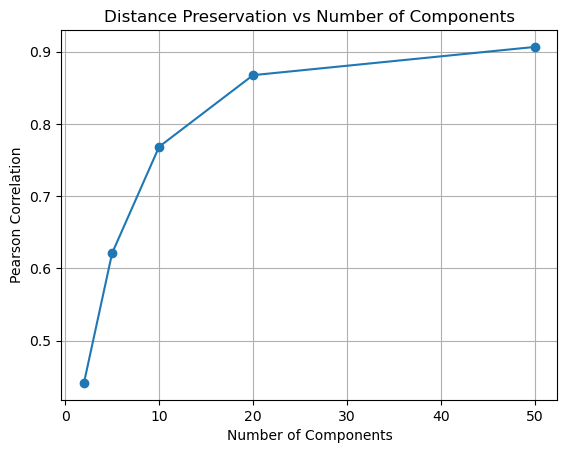

In [67]:
# Plot original/embedded distance correlation as n_components increases
import matplotlib.pyplot as plt
n_components_list = [2, 5, 10, 20, 50]
correlations = []
for n_components in n_components_list:
    planner = toy_problem.InterpolationPlanner(problem, n_components=n_components)
    embeddings = planner.embeddings
    embedded_distances = pairwise_distances(embeddings)
    correlation, _ = pearsonr(original_distances.flatten(), embedded_distances.flatten())
    correlations.append(correlation)
plt.plot(n_components_list, correlations, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Pearson Correlation')
plt.title('Distance Preservation vs Number of Components')
plt.grid()
plt.show()

In [68]:
print(correlations)

[np.float64(0.4414449193604084), np.float64(0.6210852257205454), np.float64(0.7683366271425744), np.float64(0.8674646191057231), np.float64(0.9065467622396648)]


In [69]:
# can we also test for 100 components?
planner = toy_problem.InterpolationPlanner(problem, n_components=10)
embeddings = planner.embeddings
embedded_distances = pairwise_distances(embeddings)
correlation, _ = pearsonr(original_distances.flatten(), embedded_distances.flatten())
print(f"Pearson correlation with 100 components: {correlation:.4f}")

/home/de7281/miniconda3/envs/interp_env/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Pearson correlation with 100 components: 0.7671


In [70]:
np.linalg.norm(embedded_distances - original_distances)

np.float64(31.40970950056287)

In [71]:
# compute the n-dimensional centering matrix
J = np.eye(problem.n_nodes) - (1 / problem.n_nodes) * np.ones((problem.n_nodes, problem.n_nodes))
B = -0.5 * J @ (original_distances ** 2) @ J
eigenvalues, eigenvectors = np.linalg.eigh(B)

In [73]:
import numpy as np

def two_set_euclidean_embedding(F, k=None, tol=1e-10):
    """
    Compute two embeddings A, B in R^k such that ||A[i] - B[j]|| ≈ F[i,j].
    
    Parameters
    ----------
    F : (n, n) ndarray
        Pairwise distance matrix (not necessarily symmetric).
    k : int or None
        Target dimension. If None, use full rank.
    tol : float
        Eigenvalue tolerance for numerical rank.
    
    Returns
    -------
    A, B : (n, k) ndarrays
        Two embeddings (start and end points).
    B_centered : (n, n) ndarray
        The double-centered cross-Gram matrix.
    """
    F = np.asarray(F)
    assert F.ndim == 2 and F.shape[0] == F.shape[1], "F must be square (n x n)"
    n = F.shape[0]

    # Step 1: squared distances
    S = F ** 2

    # Step 2: double centering
    r = S.mean(axis=1, keepdims=True)
    c = S.mean(axis=0, keepdims=True)
    mu = S.mean()
    Bmat = -0.5 * (S - r - c + mu)

    # Step 3: SVD / eigen decomposition
    U, s, Vt = np.linalg.svd(Bmat)
    if k is None:
        k = np.sum(s > tol)
    k = min(k, len(s))
    sqrt_s = np.sqrt(np.clip(s[:k], 0, None))
    A_centered = U[:, :k] * sqrt_s
    B_centered = Vt[:k, :].T * sqrt_s

    # Step 4: solve for translation vector h (optional correction)
    # Compute residual R = S - ||A-B||^2
    D_approx_sq = (
        np.sum(A_centered**2, axis=1, keepdims=True)
        + np.sum(B_centered**2, axis=1, keepdims=True).T
        - 2 * A_centered @ B_centered.T
    )
    R = S - D_approx_sq

    # Linear least squares for h and s = ||h||^2
    X = np.concatenate([
        2 * (A_centered[:, None, :] - B_centered[None, :, :]).reshape(-1, k),
        np.ones((n*n, 1))
    ], axis=1)
    y = R.reshape(-1, 1)
    sol, *_ = np.linalg.lstsq(X, y, rcond=None)
    h, s_val = sol[:-1, 0], sol[-1, 0]

    # check consistency s ≈ ||h||^2
    consistent = np.isclose(s_val, np.dot(h, h), atol=1e-6)

    # Step 5: reconstruct A, B with offset (choose arbitrary origin)
    A = A_centered + h / 2
    B = B_centered - h / 2

    return A, B, Bmat, consistent

In [74]:
A, B, Bmat, consistent = two_set_euclidean_embedding(original_distances, k=10)

In [76]:
def compute_distances(A, B):
    return np.sqrt(np.maximum(np.sum(A**2, axis=1, keepdims=True) + np.sum(B**2, axis=1, keepdims=True).T - 2 * A @ B.T, 0))

In [77]:
single_distances = compute_distances(embeddings, embeddings)

In [78]:
double_distances = compute_distances(A, B)

In [79]:
np.linalg.norm(single_distances - original_distances)

np.float64(31.409709502180302)

In [80]:
np.linalg.norm(double_distances - original_distances)

np.float64(83.32236485075897)

In [92]:
planner.next_waypoint(0, 10, frac=0.5)

np.int64(10)